In [1]:
%load_ext autoreload
%autoreload 2

import astropy
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

import inspect

from apoNN.src.occam import Occam

import apogee.tools.read as apread
import apogee.tools.path as apogee_path
from apogee.tools import bitmask
import collections


from apoNN.src.datasets import ApogeeDataset,AspcapDataset

from apoNN.src.utils import generate_loss_with_masking
from apoNN.src.utils import dump
from apoNN.src.utils import load
import apoNN.src.vectors as vector

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
from sklearn.decomposition import PCA


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

apogee_path.change_dr(16)

[(['TEFF', 'LOGG', 'LOG10VDOP', 'METALS', 'C', 'N', 'O Mg Si S Ca Ti'], ['C', 'N', 'O', 'Na', 'Mg', 'Al', 'Si', 'S', 'K', 'Ca', 'Ti', 'V', 'Mn', 'Fe', 'Ni'], ['[C/M]', '[N/M]', '[O/M]', '[Na/H]', '[Mg/M]', '[Al/H]', '[Si/M]', '[S/M]', '[K/H]', '[Ca/M]', '[Ti/M]', '[V/H]', '[Mn/H]', '[Fe/H]', '[Ni/H]'], [0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1])]


In [2]:
allStar =  load("allStar_training_restricted")
dataset=  AspcapDataset(filename="aspcap_restricted",tensor_type=torch.FloatTensor,recenter=True)
n_data=10000

We discard those spectra without measured abundances

In [3]:
upper_temp_cut = allStar["Teff"]<7000
lower_temp_cut = allStar["Teff"]>3500
lower_g_cut = allStar["logg"]>1.
upper_g_cut = allStar["logg"]<3.5
snr_cut = allStar["SNR"]>100
snr_highcut = allStar["SNR"]<500
feh_outliercut = allStar["Fe_H"]>-5
o_outliercut = allStar["O_FE"]>-5
c_outliercut = allStar["C_FE"]>-5
na_outliercut = allStar["Na_FE"]>-5
mg_outliercut = allStar["Mg_FE"]>-5
si_outliercut = allStar["Si_FE"]>-5
al_outliercut = allStar["Al_FE"]>-5
s_outliercut = allStar["S_FE"]>-5
p_outliercut = allStar["P_FE"]>-5
ti_outliercut = allStar["Ti_FE"]>-5
cr_outliercut = allStar["Cr_FE"]>-5



combined_cut = lower_g_cut & upper_g_cut & lower_temp_cut & upper_temp_cut & snr_cut & snr_highcut & feh_outliercut & o_outliercut &  c_outliercut & na_outliercut & mg_outliercut & si_outliercut & al_outliercut & p_outliercut & s_outliercut & ti_outliercut & cr_outliercut

In [38]:
autoencoder = torch.load("/share/splinter/ddm/taggingProject/apogeeFactory/outputs/guild/aspcap/dim/z5b/ae_15000.p")
#autoencoder.intermediate_activation=None

small test that we are indeed correctly reconstructing spectra

/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


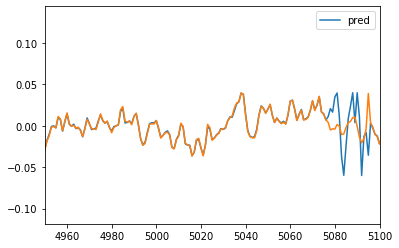

In [39]:
x = torch.tensor(dataset[1][0].unsqueeze(0).to(device))
x_pred,z_test = autoencoder(x)
plt.plot(x_pred[0].detach().cpu().numpy(),label="pred")
plt.plot(x[0].detach().cpu().numpy())
#plt.plot(dataset[1][2])

plt.xlim(4950,5100)
plt.legend()

### Creating full dataset vectors

In [148]:
considered_parameters = ["Teff","logg","Fe_H","O_FE","C_FE","Na_FE","Mg_FE","Si_FE","S_FE","Al_FE","P_FE","Ni_FE"] 
y = vector.Vector(np.array([allStar[:n_data][combined_cut[:n_data]][param] for param in considered_parameters])[:,:n_data].T)
y_astronn = vector.AstroNNVector(allStar[:n_data][combined_cut[:n_data]],considered_parameters)

In [41]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2,interaction_only=True)

In [141]:
z = vector.LatentVector(dataset,autoencoder,n_data,order=2,interaction_only=False)


/share/splinter/ddm/taggingProject/apogeeFactory/apoNN/src/vectors.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  _,z = self.autoencoder(torch.tensor(self.dataset[idx][0]).to(device).unsqueeze(0))


In [142]:
z = vector.Vector(z.raw[combined_cut[:n_data]])

In [146]:
w = vector.LinearTransformation(z,y)
nonlinear_w = vector.NonLinearTransformation(z,y)
nonlinear_w.fit(n_epochs=200)

err:0.18771980702877045
err:0.21256782114505768
err:0.14725901186466217
err:0.1490744948387146
err:0.11643414944410324
err:0.13454000651836395
err:0.09195373952388763
err:0.048428989946842194
err:0.08376774191856384
err:0.08296621590852737
err:0.0413777232170105
err:0.042465973645448685
err:0.06060056760907173
err:0.03468356281518936
err:0.05152050778269768
err:0.03965281322598457
err:0.03530247509479523
err:0.04375403746962547
err:0.03794925659894943
err:0.036393702030181885
err:0.031102817505598068
err:0.03620234131813049
err:0.0372016616165638
err:0.028021100908517838
err:0.029674870893359184
err:0.02844761684536934
err:0.04832690209150314
err:0.023953014984726906
err:0.02568369358778
err:0.03220922499895096
err:0.03351220488548279
err:0.045225922018289566
err:0.03862461820244789
err:0.05711367353796959
err:0.03448530659079552
err:0.02794823981821537
err:0.031233133748173714
err:0.02219623140990734
err:0.02944503165781498
err:0.02106163650751114
err:0.04427427425980568
err:0.0224312

err:0.012105868197977543
err:0.010822582058608532
err:0.013659393414855003
err:0.011042202822864056
err:0.010004684329032898
err:0.015217294916510582
err:0.010867251083254814
err:0.009992391802370548
err:0.01364013273268938
err:0.013780444860458374
err:0.013122530654072762
err:0.012873377650976181
err:0.012781593948602676
err:0.015719329938292503
err:0.012435350567102432
err:0.010629363358020782
err:0.008394765667617321
err:0.010336987674236298
err:0.008731268346309662
err:0.01308039203286171
err:0.01016348134726286
err:0.010134021751582623
err:0.011233458295464516
err:0.012241259217262268
err:0.010737822391092777
err:0.013063965365290642
err:0.01180832739919424
err:0.013492371886968613
err:0.013008092530071735
err:0.010345312766730785
err:0.009356369264423847
err:0.010106927715241909
err:0.01624118909239769
err:0.009615969844162464
err:0.010126096196472645
err:0.011324281804263592
err:0.011622588150203228
err:0.01079325657337904
err:0.01213825773447752
err:0.011578955687582493
err:0.0

err:0.010801310651004314
err:0.010429206304252148
err:0.012588012032210827
err:0.008671232499182224
err:0.011604313738644123
err:0.00991655234247446
err:0.009421237744390965
err:0.00883470755070448
err:0.0077808271162211895
err:0.010325707495212555
err:0.009540866129100323
err:0.009841137565672398
err:0.011081126518547535
err:0.010080579668283463
err:0.009062127210199833
err:0.008515436202287674
err:0.010099843144416809
err:0.008428561501204967
err:0.010328863747417927
err:0.010591192170977592
err:0.012323069386184216
err:0.013799266889691353
err:0.012379629537463188
err:0.014885969460010529
err:0.015178127214312553
err:0.014579232782125473
err:0.01389542780816555
err:0.009055836126208305
err:0.011773115955293179
err:0.009221167303621769
err:0.010161218233406544
err:0.009594780392944813
err:0.012181168422102928
err:0.009610466659069061
err:0.008861733600497246
err:0.013130344450473785
err:0.009540107101202011
err:0.008671852760016918
err:0.01248947810381651
err:0.012464986182749271
err

err:0.013441582210361958
err:0.010377262718975544
err:0.009248759597539902
err:0.00741781247779727
err:0.008744559250772
err:0.007372625637799501
err:0.011648315005004406
err:0.008619801141321659
err:0.009052829816937447
err:0.009826760739088058
err:0.0107033746317029
err:0.009468276053667068
err:0.011116315610706806
err:0.009680268354713917
err:0.010743793100118637
err:0.011574678122997284
err:0.008784603327512741
err:0.007600553799420595
err:0.008421267382800579
err:0.014860537834465504
err:0.008298076689243317
err:0.009027160704135895
err:0.009959705173969269
err:0.010505100712180138
err:0.009226861409842968
err:0.010373735800385475
err:0.010591655038297176
err:0.00981179904192686
err:0.009309177286922932
err:0.010609902441501617
err:0.010250714607536793
err:0.009979127906262875
err:0.012307957746088505
err:0.008349942043423653
err:0.010790267959237099
err:0.009328577667474747
err:0.008916294202208519
err:0.008470287546515465
err:0.00752341840416193
err:0.009810739196836948
err:0.00

err:0.007848304696381092
err:0.009180745109915733
err:0.008003367111086845
err:0.009608753956854343
err:0.00977245531976223
err:0.011419101618230343
err:0.012635867111384869
err:0.011321389116346836
err:0.013648437336087227
err:0.014405684545636177
err:0.013796946965157986
err:0.012830596417188644
err:0.008350685238838196
err:0.011150142177939415
err:0.00876514334231615
err:0.009069064632058144
err:0.008832083083689213
err:0.010967087931931019
err:0.008821903727948666
err:0.00823693536221981
err:0.012405705638229847
err:0.009032977744936943
err:0.00808644387871027
err:0.012077521532773972
err:0.011386706493794918
err:0.011061315424740314
err:0.010499246418476105
err:0.010951370000839233
err:0.01302642747759819
err:0.010017111897468567
err:0.009041459299623966
err:0.007213696837425232
err:0.008463485166430473
err:0.007106661796569824
err:0.011402863077819347
err:0.008361773565411568
err:0.008826968260109425
err:0.009519432671368122
err:0.010407567024230957
err:0.009177721105515957
err:0

err:0.014445052482187748
err:0.007994233630597591
err:0.008696125820279121
err:0.009590246714651585
err:0.010143428109586239
err:0.008773780427873135
err:0.009829618036746979
err:0.010303310118615627
err:0.00946560874581337
err:0.008918066509068012
err:0.01005425676703453
err:0.009682218544185162
err:0.009513376280665398
err:0.012034003622829914
err:0.008038509637117386
err:0.010026592761278152
err:0.008854237385094166
err:0.008503041230142117
err:0.00807235762476921
err:0.00735359825193882
err:0.00936687458306551
err:0.008813580498099327
err:0.00881283637136221
err:0.010279121808707714
err:0.009089590981602669
err:0.008124615997076035
err:0.007645187433809042
err:0.008977756835520267
err:0.007808656897395849
err:0.009359356947243214
err:0.009475352242588997
err:0.011165724135935307
err:0.012296311557292938
err:0.010999117977917194
err:0.013245669193565845
err:0.01412166003137827
err:0.013477752916514874
err:0.012513832189142704
err:0.008161559700965881
err:0.01093413308262825
err:0.00

err:0.007995691150426865
err:0.012061924673616886
err:0.008738214150071144
err:0.007858320139348507
err:0.011926447972655296
err:0.010898970998823643
err:0.010669604875147343
err:0.01001624297350645
err:0.010538107715547085
err:0.012479632161557674
err:0.009647929109632969
err:0.008768080733716488
err:0.006939266808331013
err:0.00817585363984108
err:0.006867568474262953
err:0.010977141559123993
err:0.008138805627822876
err:0.008535768836736679
err:0.009223384782671928
err:0.010129873640835285
err:0.008865528739988804
err:0.010204051621258259
err:0.00865843240171671
err:0.009399818256497383
err:0.01109886635094881
err:0.008108585141599178
err:0.006861391011625528
err:0.007678991183638573
err:0.014288670383393764
err:0.0079058101400733
err:0.008597752079367638
err:0.00946366973221302
err:0.010016600601375103
err:0.008642308413982391
err:0.009642371907830238
err:0.01014003623276949
err:0.009368634782731533
err:0.008772820234298706
err:0.009876939468085766
err:0.009466868825256824
err:0.00

err:0.01187595259398222
err:0.007879587821662426
err:0.009559566155076027
err:0.008617398329079151
err:0.008238201029598713
err:0.007900436408817768
err:0.00724068796262145
err:0.009073875844478607
err:0.00859738513827324
err:0.00848601758480072
err:0.010013505816459656
err:0.00884192530065775
err:0.007821186445653439
err:0.007392010185867548
err:0.008761502802371979
err:0.007572366390377283
err:0.009059151634573936
err:0.009185383096337318
err:0.010831429623067379
err:0.011897910386323929
err:0.010494387708604336
err:0.012729166075587273
err:0.013715293258428574
err:0.013116415590047836
err:0.012103480286896229
err:0.007955051027238369
err:0.010719018056988716
err:0.008303623646497726
err:0.008360140025615692
err:0.008331289514899254
err:0.010263615287840366
err:0.00834729429334402
err:0.007874772883951664
err:0.011881628073751926
err:0.008623641915619373
err:0.00776165584102273
err:0.01179297361522913
err:0.010758856311440468
err:0.010513663291931152
err:0.009827586822211742
err:0.01

err:0.006793730426579714
err:0.00796687975525856
err:0.0066930134780704975
err:0.010843710042536259
err:0.008021675981581211
err:0.008306813426315784
err:0.00901329517364502
err:0.009962324984371662
err:0.00866914726793766
err:0.009884276427328587
err:0.008421408012509346
err:0.008980846963822842
err:0.010988089255988598
err:0.007918138988316059
err:0.0066531142219901085
err:0.007471957243978977
err:0.013947525061666965
err:0.007735459133982658
err:0.00842249859124422
err:0.00925719179213047
err:0.00981006771326065
err:0.008455847389996052
err:0.0094148525968194
err:0.009891107678413391
err:0.009168555028736591
err:0.008578999899327755
err:0.009598234668374062
err:0.009156795218586922
err:0.009135588072240353
err:0.011775121092796326
err:0.007782472763210535
err:0.009327128529548645
err:0.008519505150616169
err:0.008119492791593075
err:0.007845179177820683
err:0.007211050949990749
err:0.00893664825707674
err:0.008481898345053196
err:0.008330510929226875
err:0.009893902577459812
err:0.0

err:0.007623995188623667
err:0.007222816348075867
err:0.008634883910417557
err:0.00749353040009737
err:0.008810960687696934
err:0.008988173678517342
err:0.010559606365859509
err:0.011577794328331947
err:0.010190984234213829
err:0.012422122992575169
err:0.013466288335621357
err:0.012794312089681625
err:0.01190106850117445
err:0.007812616415321827
err:0.010583334602415562
err:0.008123813197016716
err:0.008119949139654636
err:0.008129367604851723
err:0.009922735393047333
err:0.008170473389327526
err:0.007676576729863882
err:0.011589666828513145
err:0.008468464016914368
err:0.007592204492539167
err:0.011661196127533913
err:0.01052978727966547
err:0.010299107059836388
err:0.00956180039793253
err:0.010100546292960644
err:0.011898207478225231
err:0.009264498017728329
err:0.008467205800116062
err:0.0066631752997636795
err:0.007868153043091297
err:0.006619607098400593
err:0.010572810657322407
err:0.007877467200160027
err:0.008185083046555519
err:0.00889816414564848
err:0.009829060174524784
err:

err:0.010785889811813831
err:0.007716326974332333
err:0.006436461582779884
err:0.007265104446560144
err:0.01355983130633831
err:0.007643021177500486
err:0.00829662661999464
err:0.009109430946409702
err:0.009633691981434822
err:0.008328028954565525
err:0.009244113229215145
err:0.0096734082326293
err:0.009048125706613064
err:0.008421492762863636
err:0.009378744289278984
err:0.008936204947531223
err:0.008928683586418629
err:0.011688526719808578
err:0.007664841134101152
err:0.009039699099957943
err:0.008384773507714272
err:0.007957754656672478
err:0.007713812403380871
err:0.007132896687835455
err:0.00876570213586092
err:0.00833660364151001
err:0.008160540834069252
err:0.009712815284729004
err:0.008561973460018635
err:0.007527716923505068
err:0.007139231543987989
err:0.008536466397345066
err:0.007434416562318802
err:0.008691060356795788
err:0.008883345872163773
err:0.010414647869765759
err:0.011427327990531921
err:0.01003355998545885
err:0.012223368510603905
err:0.013324624858796597
err:0.0

err:0.007894918322563171
err:0.007981953211128712
err:0.009762980043888092
err:0.008065126836299896
err:0.00749285239726305
err:0.01136267650872469
err:0.0083714434877038
err:0.007464026100933552
err:0.011671589687466621
err:0.010462773032486439
err:0.010142620652914047
err:0.009343905374407768
err:0.009868324734270573
err:0.01174261886626482
err:0.00904745701700449
err:0.008315092884004116
err:0.00655706413090229
err:0.007712755352258682
err:0.00650783209130168
err:0.010519909672439098
err:0.007921261712908745
err:0.007990407757461071
err:0.008763241581618786
err:0.009732295759022236
err:0.008428366854786873
err:0.009543364867568016
err:0.008016341365873814
err:0.008613379672169685
err:0.010793386027216911
err:0.007629148196429014
err:0.006363776512444019
err:0.007201617117971182
err:0.01339663565158844
err:0.007573775015771389
err:0.008216462098062038
err:0.009030244313180447
err:0.009571737609803677
err:0.008295328356325626
err:0.009180811233818531
err:0.009561597369611263
err:0.008

err:0.00875695887953043
err:0.008751160465180874
err:0.011558564379811287
err:0.007544178981333971
err:0.008780810981988907
err:0.008257973939180374
err:0.007818442769348621
err:0.007592511363327503
err:0.007020983844995499
err:0.008614723570644855
err:0.00818792823702097
err:0.008032252080738544
err:0.009554432705044746
err:0.008407601155340672
err:0.007380065508186817
err:0.007003153208643198
err:0.008406601846218109
err:0.0073194727301597595
err:0.008491691201925278
err:0.008729592896997929
err:0.010178999975323677
err:0.011189920827746391
err:0.009787934832274914
err:0.011986210942268372
err:0.01311499159783125
err:0.01244831271469593
err:0.01154683344066143
err:0.007610388100147247
err:0.010352726094424725
err:0.00788858626037836
err:0.007804576773196459
err:0.00791375432163477
err:0.009688766673207283
err:0.007995893247425556
err:0.007417116314172745
err:0.011300631798803806
err:0.008309937082231045
err:0.007391151040792465
err:0.011585147120058537
err:0.010406386107206345
err:0.

err:0.008870482444763184
err:0.008195338770747185
err:0.006453183013945818
err:0.0075759985484182835
err:0.006404708605259657
err:0.010248037055134773
err:0.007812132127583027
err:0.007833417505025864
err:0.008607971481978893
err:0.009555636905133724
err:0.008305853232741356
err:0.009347818791866302
err:0.007830651476979256
err:0.008387845940887928
err:0.010620269924402237
err:0.007491190452128649
err:0.006198503542691469
err:0.007052240427583456
err:0.01308245025575161
err:0.007479836232960224
err:0.008094512857496738
err:0.008908526040613651
err:0.009483982808887959
err:0.00821648072451353
err:0.009076813235878944
err:0.009381665848195553
err:0.008855367079377174
err:0.008260386064648628
err:0.009068355895578861
err:0.008681358769536018
err:0.008663908578455448
err:0.011492674238979816
err:0.007478967774659395
err:0.008676492609083652
err:0.008209227584302425
err:0.007757427170872688
err:0.0075507936999201775
err:0.006940857507288456
err:0.008543928153812885
err:0.008118350058794022


err:0.009392879903316498
err:0.008275782689452171
err:0.007251126226037741
err:0.006887760479003191
err:0.008307764306664467
err:0.007267259061336517
err:0.008325156755745411
err:0.008577845059335232
err:0.010004548355937004
err:0.01101272739470005
err:0.00960058905184269
err:0.011766587384045124
err:0.012971174903213978
err:0.012275440618395805
err:0.011313535273075104
err:0.007519122213125229
err:0.01023124810308218
err:0.007774317637085915
err:0.007691151462495327
err:0.007823669351637363
err:0.00958790723234415
err:0.0078850407153368
err:0.00728687783703208
err:0.011170560494065285
err:0.008213688619434834
err:0.007287967950105667
err:0.011441533453762531
err:0.010315151885151863
err:0.009990781545639038
err:0.009062542580068111
err:0.00957742054015398
err:0.011360817588865757
err:0.00877601932734251
err:0.008135784417390823
err:0.006390389520674944
err:0.0075130704790353775
err:0.006364135537296534
err:0.01016300730407238
err:0.007776216138154268
err:0.007753327954560518
err:0.008

err:0.007369163446128368
err:0.006088110618293285
err:0.00693434476852417
err:0.012860833667218685
err:0.007409231271594763
err:0.008002188056707382
err:0.008823556825518608
err:0.009415623731911182
err:0.008156949654221535
err:0.008982956409454346
err:0.009170357137918472
err:0.008778147399425507
err:0.008167704567313194
err:0.008961622603237629
err:0.008560605347156525
err:0.00852382555603981
err:0.01138088759034872
err:0.0073870327323675156
err:0.0084928497672081
err:0.008131365291774273
err:0.00764374528080225
err:0.0074635823257267475
err:0.006832845974713564
err:0.008424350060522556
err:0.008007842116057873
err:0.00785994902253151
err:0.00932149775326252
err:0.008218958042562008
err:0.007184486370533705
err:0.006829069461673498
err:0.008241049014031887
err:0.007221385836601257
err:0.008253301493823528
err:0.008500544354319572
err:0.009902874939143658
err:0.010925179347395897
err:0.00950072892010212
err:0.011670257896184921
err:0.012864811345934868
err:0.012153437361121178
err:0.0

err:0.010115670040249825
err:0.007662083487957716
err:0.007563011255115271
err:0.007743614725768566
err:0.009472298435866833
err:0.007788586895912886
err:0.0071613066829741
err:0.011121472343802452
err:0.008126456290483475
err:0.0071988217532634735
err:0.01121054869145155
err:0.010245926678180695
err:0.009876945987343788
err:0.008909933269023895
err:0.009454206563532352
err:0.011156043969094753
err:0.008628248237073421
err:0.008040819317102432
err:0.006360091734677553
err:0.007402544375509024
err:0.0062750340439379215
err:0.010085475631058216
err:0.007738906890153885
err:0.0076871938072144985
err:0.008428839035332203
err:0.00937225017696619
err:0.008159508928656578
err:0.009098619222640991
err:0.007678869646042585
err:0.00812375359237194
err:0.010484692640602589
err:0.007363804150372744
err:0.006075132172554731
err:0.006912454031407833
err:0.012738204561173916
err:0.007347018923610449
err:0.00795364286750555
err:0.008783609606325626
err:0.009410079568624496
err:0.00812893733382225
err:

err:0.0084324786439538
err:0.01126912608742714
err:0.007283597253262997
err:0.008318536914885044
err:0.008060569874942303
err:0.007555982563644648
err:0.0074004908092319965
err:0.006735820323228836
err:0.008313486352562904
err:0.00791798997670412
err:0.007771085482090712
err:0.009195449762046337
err:0.008118806406855583
err:0.007101834751665592
err:0.006742717698216438
err:0.008138942532241344
err:0.0071609546430408955
err:0.008133122697472572
err:0.008377356454730034
err:0.00974864698946476
err:0.010792622342705727
err:0.009353848174214363
err:0.01151012722402811
err:0.012741346843540668
err:0.011976233683526516
err:0.011003674007952213
err:0.007376961875706911
err:0.010036101564764977
err:0.00760357640683651
err:0.007482437416911125
err:0.007700479123741388
err:0.009382721036672592
err:0.007737068459391594
err:0.007107988465577364
err:0.011050048284232616
err:0.008105200715363026
err:0.007152833975851536
err:0.011135604232549667
err:0.010195047594606876
err:0.009827117435634136
err:0

err:0.0063033332116901875
err:0.007307748775929213
err:0.006224592681974173
err:0.009912002831697464
err:0.007695866748690605
err:0.007587127853184938
err:0.008341874927282333
err:0.009265271946787834
err:0.008068746887147427
err:0.0089577566832304
err:0.007550626061856747
err:0.007978144101798534
err:0.01038067601621151
err:0.007269449532032013
err:0.005993423517793417
err:0.006815183442085981
err:0.012571737170219421
err:0.007299491669982672
err:0.00786607712507248
err:0.008685491979122162
err:0.00935473944991827
err:0.00807837676256895
err:0.008885097689926624
err:0.008944242261350155
err:0.008643193170428276
err:0.008020336739718914
err:0.00882604718208313
err:0.008409759029746056
err:0.008392928168177605
err:0.011216175742447376
err:0.007237242069095373
err:0.008224789053201675
err:0.008021727204322815
err:0.0075076790526509285
err:0.0073578692972660065
err:0.0066935340873897076
err:0.00826004333794117
err:0.00787353515625
err:0.007729115895926952
err:0.009123442694544792
err:0.00

err:0.00803244486451149
err:0.008263695985078812
err:0.009605655446648598
err:0.01070096343755722
err:0.00920700654387474
err:0.011346117593348026
err:0.01264036726206541
err:0.011843875981867313
err:0.010857244953513145
err:0.007308857515454292
err:0.009946093894541264
err:0.007514122407883406
err:0.007372914347797632
err:0.00764656625688076
err:0.00928452704101801
err:0.007659603841602802
err:0.006998831406235695
err:0.011026158928871155
err:0.008046824485063553
err:0.007085717748850584
err:0.010958719067275524
err:0.010158112272620201
err:0.009743697009980679
err:0.00874146819114685
err:0.009316920302808285
err:0.010936307720839977
err:0.008463814854621887
err:0.0078881261870265
err:0.006291693076491356
err:0.007269629742950201
err:0.0061955233104527
err:0.009891806170344353
err:0.007696634158492088
err:0.007558456622064114
err:0.008289851248264313
err:0.009221299551427364
err:0.00803773757070303
err:0.008891469798982143
err:0.007523730862885714
err:0.007915408350527287
err:0.010350

err:0.012424624525010586
err:0.007269577588886023
err:0.007782468106597662
err:0.008610878139734268
err:0.009310074150562286
err:0.008041003718972206
err:0.008834407664835453
err:0.008823191747069359
err:0.008597089909017086
err:0.007917269133031368
err:0.008726503700017929
err:0.008324346505105495
err:0.008309408091008663
err:0.011121769435703754
err:0.007184938061982393
err:0.008081786334514618
err:0.007956046611070633
err:0.007422714494168758
err:0.0073075988329946995
err:0.006629836745560169
err:0.008173740468919277
err:0.007792870979756117
err:0.0076651861891150475
err:0.009010864421725273
err:0.007990043610334396
err:0.006984304171055555
err:0.006643461529165506
err:0.008004764094948769
err:0.0070788124576210976
err:0.007983322255313396
err:0.008214485831558704
err:0.009550930000841618
err:0.010632917284965515
err:0.009118250571191311
err:0.011271785013377666
err:0.012575270608067513
err:0.011774012818932533
err:0.010792898014187813
err:0.007269387599080801
err:0.0098830545321106

err:0.007588679902255535
err:0.006928127724677324
err:0.01091486681252718
err:0.007990160025656223
err:0.007032858673483133
err:0.01080128364264965
err:0.010089089162647724
err:0.009686826728284359
err:0.008671902120113373
err:0.009217408485710621
err:0.010783394798636436
err:0.008367911912500858
err:0.007796363905072212
err:0.006225102115422487
err:0.00720606604591012
err:0.006161642260849476
err:0.00967976450920105
err:0.007653054781258106
err:0.007456448394805193
err:0.008211636915802956
err:0.009126326069235802
err:0.007954709231853485
err:0.008777611888945103
err:0.007387744728475809
err:0.007802365813404322
err:0.010176293551921844
err:0.00713309645652771
err:0.005862629506736994
err:0.006669391877949238
err:0.012346519157290459
err:0.007247780449688435
err:0.007751630153506994
err:0.008571396581828594
err:0.009281665086746216
err:0.008016852661967278
err:0.008800268173217773
err:0.008755742572247982
err:0.008577368222177029
err:0.007887049578130245
err:0.008656957186758518
err:0

err:0.007981992326676846
err:0.007899454794824123
err:0.00734304916113615
err:0.007246977649629116
err:0.006579060107469559
err:0.008104823529720306
err:0.007719362620264292
err:0.0076042478904128075
err:0.008908126503229141
err:0.00791432149708271
err:0.006933195050805807
err:0.0065903919748961926
err:0.007943806238472462
err:0.007098251488059759
err:0.007914227433502674
err:0.008144944906234741
err:0.00943681225180626
err:0.010528719052672386
err:0.009011509828269482
err:0.011167103424668312
err:0.012466669082641602
err:0.011652057990431786
err:0.01070714183151722
err:0.007214362733066082
err:0.009810904040932655
err:0.007391493301838636
err:0.007234359160065651
err:0.007574880961328745
err:0.0091562420129776
err:0.007565735373646021
err:0.0068762716837227345
err:0.010818863287568092
err:0.007967778481543064
err:0.007002430967986584
err:0.010663964785635471
err:0.010028041899204254
err:0.009648198261857033
err:0.008620931766927242
err:0.009191663935780525
err:0.010721337050199509
err

err:0.0061200642958283424
err:0.009630836546421051
err:0.007611133623868227
err:0.007417064625769854
err:0.008132603019475937
err:0.009023998863995075
err:0.007900393567979336
err:0.00866634026169777
err:0.0073408749885857105
err:0.0076695652678608894
err:0.010110773146152496
err:0.00708770053461194
err:0.005797215271741152
err:0.006598144304007292
err:0.012223387137055397
err:0.00723544554784894
err:0.007704474497586489
err:0.00851198099553585
err:0.00922939833253622
err:0.0079682981595397
err:0.008736672811210155
err:0.008655758574604988
err:0.008522718213498592
err:0.007786343339830637
err:0.008592258207499981
err:0.008212954737246037
err:0.008175329305231571
err:0.01100935973227024
err:0.007112721912562847
err:0.00790513027459383
err:0.007869062945246696
err:0.007303093560039997
err:0.0072129457257688046
err:0.006529997568577528
err:0.0080560352653265
err:0.00768352672457695
err:0.007582779973745346
err:0.008874627761542797
err:0.007886935956776142
err:0.006896022241562605
err:0.00

err:0.00806434452533722
err:0.009339762851595879
err:0.010446140542626381
err:0.008872702717781067
err:0.011025549843907356
err:0.012366767972707748
err:0.01155178900808096
err:0.010602894239127636
err:0.0071699293330311775
err:0.009729924611747265
err:0.007302975747734308
err:0.007153595332056284
err:0.007545372936874628
err:0.009120708331465721
err:0.007499995641410351
err:0.006797397509217262
err:0.01080233883112669
err:0.007925034500658512
err:0.006955005694180727
err:0.010600642301142216
err:0.010025698691606522
err:0.009620781056582928
err:0.008548405952751637
err:0.009100561030209064
err:0.010662933811545372
err:0.008259262889623642
err:0.007672826759517193
err:0.00620310241356492
err:0.007108788471668959
err:0.006105890963226557
err:0.00973474606871605
err:0.007687543984502554
err:0.007410189602524042
err:0.008105057291686535
err:0.009016216732561588
err:0.007891884073615074
err:0.008643748238682747
err:0.0073639205656945705
err:0.007659755647182465
err:0.01017667818814516
err:

err:0.006537765730172396
err:0.012107903137803078
err:0.007207802496850491
err:0.007643440738320351
err:0.008431590162217617
err:0.009169472381472588
err:0.007926392368972301
err:0.008680297993123531
err:0.008547186851501465
err:0.00847639236599207
err:0.007686837110668421
err:0.008497942239046097
err:0.008149952627718449
err:0.0080929696559906
err:0.010941434651613235
err:0.007062934339046478
err:0.007797111291438341
err:0.0078170420601964
err:0.007226988673210144
err:0.00716826319694519
err:0.006477685179561377
err:0.0079707195982337
err:0.007608389016240835
err:0.007527785375714302
err:0.008800795301795006
err:0.007830454967916012
err:0.006850528996437788
err:0.0065249796025455
err:0.007833504118025303
err:0.0070002079010009766
err:0.007796797901391983
err:0.008041609078645706
err:0.009307734668254852
err:0.010396392084658146
err:0.00881322380155325
err:0.010977759957313538
err:0.012293565087020397
err:0.011529042385518551
err:0.01054186001420021
err:0.007133040577173233
err:0.00968

err:0.0075066545978188515
err:0.009078266099095345
err:0.007458692416548729
err:0.006739848759025335
err:0.010641297325491905
err:0.007889065891504288
err:0.006904425099492073
err:0.010425666347146034
err:0.009979898110032082
err:0.009587856009602547
err:0.008455575443804264
err:0.009042096324265003
err:0.010480224154889584
err:0.008185221813619137
err:0.0075940825045108795
err:0.006100698374211788
err:0.007046044804155827
err:0.006085536442697048
err:0.009424570947885513
err:0.00754484673961997
err:0.007317268289625645
err:0.00801919586956501
err:0.008898349478840828
err:0.007806695532053709
err:0.008513935841619968
err:0.007221304811537266
err:0.0075387717224657536
err:0.009960576891899109
err:0.006963389925658703
err:0.0056739985011518
err:0.006483376957476139
err:0.01204973366111517
err:0.007198108360171318
err:0.007610892411321402
err:0.008391951210796833
err:0.009138891473412514
err:0.007907356135547161
err:0.00865157600492239
err:0.008508355356752872
err:0.008456268347799778
err

err:0.007015333976596594
err:0.007734773214906454
err:0.007769367657601833
err:0.007148957345634699
err:0.0071378289721906185
err:0.0064348699524998665
err:0.007906852290034294
err:0.007549428381025791
err:0.007472365163266659
err:0.008733676746487617
err:0.007773868273943663
err:0.006815051194280386
err:0.006488163489848375
err:0.007793982047587633
err:0.006955903489142656
err:0.007745012640953064
err:0.008002636954188347
err:0.009225643239915371
err:0.01029360294342041
err:0.0087052620947361
err:0.0108912643045187
err:0.012186502106487751
err:0.011432517319917679
err:0.010445068590342999
err:0.007089035119861364
err:0.009627962484955788
err:0.007240433245897293
err:0.007073377259075642
err:0.007482396904379129
err:0.009073012508451939
err:0.007413187995553017
err:0.006706655956804752
err:0.01073513738811016
err:0.007882298901677132
err:0.0068877278827130795
err:0.010414257645606995
err:0.010013345628976822
err:0.009575078263878822
err:0.008434128947556019
err:0.009010815992951393
err

err:0.006993492599576712
err:0.006064326502382755
err:0.009506238624453545
err:0.007615880575031042
err:0.0073079923167824745
err:0.007950063794851303
err:0.008839523419737816
err:0.007768501061946154
err:0.008463500998914242
err:0.007241822313517332
err:0.007474241312593222
err:0.009974156506359577
err:0.006953001022338867
err:0.005639951676130295
err:0.006452867295593023
err:0.011956771835684776
err:0.007176197599619627
err:0.0075822919607162476
err:0.008337709121406078
err:0.00912391860038042
err:0.007883596234023571
err:0.008617301471531391
err:0.008425691165030003
err:0.008414551615715027
err:0.007612079381942749
err:0.008376278914511204
err:0.008087857626378536
err:0.008004453033208847
err:0.010852111503481865
err:0.006986997090280056
err:0.007691941224038601
err:0.00775211350992322
err:0.00711195170879364
err:0.007117073051631451
err:0.0063972738571465015
err:0.007878110744059086
err:0.007515430450439453
err:0.0074493917636573315
err:0.008689481765031815
err:0.007745595183223486

err:0.0077215214259922504
err:0.006932060234248638
err:0.007690161466598511
err:0.00794615875929594
err:0.009133320301771164
err:0.01021829154342413
err:0.00862287636846304
err:0.010804902762174606
err:0.012080604210495949
err:0.0113254738971591
err:0.01034396793693304
err:0.0070338123477995396
err:0.009553319774568081
err:0.007193974684923887
err:0.007014578208327293
err:0.007445028983056545
err:0.009033131413161755
err:0.007370544597506523
err:0.006650823168456554
err:0.010631110519170761
err:0.007853290066123009
err:0.006839626003056765
err:0.010315373539924622
err:0.009967016987502575
err:0.00956573523581028
err:0.008377274498343468
err:0.008948568254709244
err:0.01041246484965086
err:0.008093701675534248
err:0.007486790418624878
err:0.006087858229875565
err:0.006969945505261421
err:0.006057570222765207
err:0.009427102282643318
err:0.0075887576676905155
err:0.007263841573148966
err:0.007921531796455383
err:0.008810342289507389
err:0.007732296362519264
err:0.008409718051552773
err:0

err:0.009838799946010113
err:0.006871250458061695
err:0.005556025076657534
err:0.006369381677359343
err:0.01185508631169796
err:0.007155951112508774
err:0.007542859762907028
err:0.008267952129244804
err:0.009075277484953403
err:0.007856463082134724
err:0.008562379516661167
err:0.008365925401449203
err:0.008389701135456562
err:0.007552163675427437
err:0.008295866660773754
err:0.008024425245821476
err:0.007932894863188267
err:0.010799538344144821
err:0.006962858140468597
err:0.007610755041241646
err:0.007716507185250521
err:0.00703922426328063
err:0.007069389335811138
err:0.006340309977531433
err:0.007816650904715061
err:0.007454657927155495
err:0.007403354626148939
err:0.008633014746010303
err:0.007708805613219738
err:0.006753557827323675
err:0.006426585838198662
err:0.0076955826953053474
err:0.00691729411482811
err:0.00766606442630291
err:0.00792558491230011
err:0.009097423404455185
err:0.010167586617171764
err:0.008569595403969288
err:0.010754583403468132
err:0.012021848931908607
err:

err:0.009480332024395466
err:0.00712797325104475
err:0.007003836799412966
err:0.007413037586957216
err:0.008983324281871319
err:0.007311628665775061
err:0.006606381852179766
err:0.010654838755726814
err:0.007826004177331924
err:0.006808481179177761
err:0.010156525298953056
err:0.009948079474270344
err:0.009546018205583096
err:0.008348098024725914
err:0.008866078220307827
err:0.010302089154720306
err:0.008060561493039131
err:0.007423240691423416
err:0.006057486869394779
err:0.006929995492100716
err:0.006048140581697226
err:0.009362217970192432
err:0.007622844539582729
err:0.007224309723824263
err:0.007859645411372185
err:0.008757725358009338
err:0.007694886531680822
err:0.008349412120878696
err:0.007155836559832096
err:0.007379716262221336
err:0.009846235625445843
err:0.006868487223982811
err:0.005544159561395645
err:0.006353161297738552
err:0.011828627437353134
err:0.007144820876419544
err:0.007533102296292782
err:0.008247793652117252
err:0.00905850250273943
err:0.007845616899430752
er

err:0.008243348449468613
err:0.00799631979316473
err:0.00788428820669651
err:0.010774065740406513
err:0.006922978907823563
err:0.0075566149316728115
err:0.007688490673899651
err:0.006983719766139984
err:0.007036535069346428
err:0.006292784586548805
err:0.007773858029395342
err:0.0074050044640898705
err:0.007368912920355797
err:0.008574125356972218
err:0.007672267034649849
err:0.006727709900587797
err:0.0063956668600440025
err:0.007646573707461357
err:0.006873715668916702
err:0.007623257115483284
err:0.007872384041547775
err:0.00901169516146183
err:0.010078683495521545
err:0.008483830839395523
err:0.010669857263565063
err:0.011914930306375027
err:0.011167618446052074
err:0.01022394374012947
err:0.0069623407907783985
err:0.00947445910423994
err:0.007142375688999891
err:0.006983483675867319
err:0.007397243287414312
err:0.008970437571406364
err:0.007302661892026663
err:0.00657146330922842
err:0.010629079304635525
err:0.007808894384652376
err:0.006778108421713114
err:0.010117887519299984
er

err:0.008308145217597485
err:0.008833860047161579
err:0.010185034945607185
err:0.007999259978532791
err:0.007384580094367266
err:0.006005646660923958
err:0.006892261561006308
err:0.006030477117747068
err:0.009279116056859493
err:0.007576907519251108
err:0.007187249138951302
err:0.007816601544618607
err:0.008688031695783138
err:0.007654628716409206
err:0.008247964084148407
err:0.007097387686371803
err:0.007320517674088478
err:0.009738224558532238
err:0.00681197177618742
err:0.005483882501721382
err:0.006291751284152269
err:0.011707035824656487
err:0.0071162208914756775
err:0.007497731130570173
err:0.008185946382582188
err:0.009020683355629444
err:0.007821805775165558
err:0.008508588187396526
err:0.008275735192000866
err:0.008337409235537052
err:0.007484749425202608
err:0.008205024525523186
err:0.007968625985085964
err:0.007840023376047611
err:0.01074762362986803
err:0.0069119916297495365
err:0.007514384109526873
err:0.007663242984563112
err:0.006950077600777149
err:0.007007375825196505


err:0.008520087227225304
err:0.0076423040591180325
err:0.006688529625535011
err:0.006361645180732012
err:0.007624799385666847
err:0.0069524869322776794
err:0.007587088737636805
err:0.007827997207641602
err:0.008948143571615219
err:0.009986319579184055
err:0.008438777178525925
err:0.01061167474836111
err:0.011826248839497566
err:0.011052391491830349
err:0.010158820077776909
err:0.0069131143391132355
err:0.009419290348887444
err:0.007122966460883617
err:0.006931380368769169
err:0.007365158759057522
err:0.00891793705523014
err:0.007275195326656103
err:0.00652230205014348
err:0.010467655025422573
err:0.007779203355312347
err:0.006736814975738525
err:0.009940389543771744
err:0.009825069457292557
err:0.009496647864580154
err:0.008302812464535236
err:0.008831046521663666
err:0.01013366412371397
err:0.007973164319992065
err:0.0073645818047225475
err:0.0059816730208694935
err:0.006880448665469885
err:0.0060334764420986176
err:0.009219282306730747
err:0.00758605170994997
err:0.007154352031648159

err:0.008643674664199352
err:0.007627172861248255
err:0.008185717277228832
err:0.007077665533870459
err:0.007271752692759037
err:0.009697891771793365
err:0.006787323392927647
err:0.005457897204905748
err:0.006256725639104843
err:0.011601370759308338
err:0.0070892381481826305
err:0.007480542175471783
err:0.00814164150506258
err:0.00898892804980278
err:0.007796711288392544
err:0.008473778143525124
err:0.008213549852371216
err:0.008306765928864479
err:0.007455625105649233
err:0.008154988288879395
err:0.007924864999949932
err:0.007772782817482948
err:0.010735058225691319
err:0.006882363464683294
err:0.007464536000043154
err:0.007637728471308947
err:0.006884338334202766
err:0.006959364749491215
err:0.006233213935047388
err:0.007706428412348032
err:0.007321659941226244
err:0.007307562977075577
err:0.00849943794310093
err:0.007626327220350504
err:0.0066751656122505665
err:0.006345116067677736
err:0.007585434243083
err:0.006856079213321209
err:0.00755669130012393
err:0.007795912679284811
err:0

err:0.011743312701582909
err:0.010985742323100567
err:0.010061328299343586
err:0.006863867398351431
err:0.009356273338198662
err:0.007075193803757429
err:0.006899034138768911
err:0.00733933923766017
err:0.00891602411866188
err:0.00721776345744729
err:0.006489034742116928
err:0.010498826391994953
err:0.0077514429576694965
err:0.006717670243233442
err:0.009866283275187016
err:0.009818059392273426
err:0.009481190703809261
err:0.008265063166618347
err:0.008750681765377522
err:0.010117992758750916
err:0.00792129710316658
err:0.007303898688405752
err:0.005993541330099106
err:0.006846184842288494
err:0.006018151994794607
err:0.009333867579698563
err:0.00765159772709012
err:0.00716946879401803
err:0.0077668288722634315
err:0.008626356720924377
err:0.007627409417182207
err:0.008164315484464169
err:0.007087871432304382
err:0.007253577001392841
err:0.009721039794385433
err:0.0067962720058858395
err:0.005456358660012484
err:0.006242037285119295
err:0.011571070179343224
err:0.00707853352651
err:0.0

err:0.007768882904201746
err:0.00844454113394022
err:0.008175496011972427
err:0.008275194093585014
err:0.007446243893355131
err:0.0081193707883358
err:0.007882197387516499
err:0.007713643833994865
err:0.010709063149988651
err:0.006846180185675621
err:0.007401750423014164
err:0.0076155769638717175
err:0.006835951004177332
err:0.006920932326465845
err:0.006173429545015097
err:0.007673580199480057
err:0.007278800010681152
err:0.0072772870771586895
err:0.008446893654763699
err:0.0075950720347464085
err:0.006650658790022135
err:0.006320890970528126
err:0.007524504791945219
err:0.006824140902608633
err:0.0075116208754479885
err:0.007733473088592291
err:0.008835101500153542
err:0.009877976030111313
err:0.008296255953609943
err:0.010442761704325676
err:0.011698526330292225
err:0.010943634435534477
err:0.010014059022068977
err:0.0068421014584600925
err:0.00933314673602581
err:0.007059138733893633
err:0.006875230465084314
err:0.007317901588976383
err:0.008911971934139729
err:0.007194120436906815

err:0.009746570140123367
err:0.00944802537560463
err:0.008228695020079613
err:0.008709984831511974
err:0.010141300037503242
err:0.007879117503762245
err:0.007268765941262245
err:0.0059704831801354885
err:0.006805431097745895
err:0.006005245726555586
err:0.009427789598703384
err:0.007655504625290632
err:0.007173498626798391
err:0.007735303603112698
err:0.00857169833034277
err:0.0076157585717737675
err:0.008106805384159088
err:0.0071035102009773254
err:0.007225304841995239
err:0.009759895503520966
err:0.006805584765970707
err:0.005441105458885431
err:0.006223601289093494
err:0.01146648544818163
err:0.007049109321087599
err:0.007430704776197672
err:0.008067731745541096
err:0.008960586972534657
err:0.007755948696285486
err:0.008405640721321106
err:0.008149965666234493
err:0.008248389698565006
err:0.007412551436573267
err:0.008102252148091793
err:0.007859908975660801
err:0.007671700324863195
err:0.010653863660991192
err:0.006821711082011461
err:0.007358118891716003
err:0.007597350515425205


err:0.007251918315887451
err:0.00839157123118639
err:0.007558339741080999
err:0.006633990444242954
err:0.006304562091827393
err:0.007453493308275938
err:0.006778102833777666
err:0.007451076526194811
err:0.007680713664740324
err:0.008749843575060368
err:0.009788546711206436
err:0.008205678313970566
err:0.01034155860543251
err:0.011613622307777405
err:0.010831587947905064
err:0.00992730725556612
err:0.006805024109780788
err:0.00930662453174591
err:0.0070382715202867985
err:0.006832432933151722
err:0.007289866916835308
err:0.008911754935979843
err:0.007173206191509962
err:0.006413811817765236
err:0.010334344580769539
err:0.007729021832346916
err:0.006650976371020079
err:0.010002263821661472
err:0.009805897250771523
err:0.009430727921426296
err:0.008217032998800278
err:0.008697432465851307
err:0.010298066772520542
err:0.007872970774769783
err:0.007258888334035873
err:0.006018288899213076
err:0.006787050049751997
err:0.006019486580044031
err:0.00968211330473423
err:0.007835367694497108
err:

err:0.007641560398042202
err:0.007150749675929546
err:0.007700979243963957
err:0.008501650765538216
err:0.007571153808385134
err:0.00801151618361473
err:0.007050339598208666
err:0.007187787909060717
err:0.009706621989607811
err:0.006765303201973438
err:0.005381142254918814
err:0.006156541872769594
err:0.011325286701321602
err:0.00701929209753871
err:0.007393182255327702
err:0.00801460724323988
err:0.00891928467899561
err:0.007723683025687933
err:0.008346173912286758
err:0.00812542624771595
err:0.008213546127080917
err:0.007386837154626846
err:0.008059633895754814
err:0.007808287162333727
err:0.007606757804751396
err:0.010621336288750172
err:0.006800384726375341
err:0.0073195938020944595
err:0.007571471855044365
err:0.006765788421034813
err:0.006867558229714632
err:0.00609629089012742
err:0.007611023727804422
err:0.007212192285805941
err:0.007224903907626867
err:0.008376090787351131
err:0.007548164576292038
err:0.006598228123039007
err:0.006275996100157499
err:0.007435499224811792
err:0

err:0.006605419330298901
err:0.009613268077373505
err:0.009656942449510098
err:0.009411048144102097
err:0.00819095503538847
err:0.008619021624326706
err:0.010024487972259521
err:0.007807228714227676
err:0.0072012473829090595
err:0.005895225331187248
err:0.006759770214557648
err:0.005987448617815971
err:0.009228305891156197
err:0.007603903766721487
err:0.007125227712094784
err:0.007681651506572962
err:0.008480154909193516
err:0.007543639745563269
err:0.007960853166878223
err:0.006992758251726627
err:0.007153116166591644
err:0.009614024311304092
err:0.00673353997990489
err:0.005352329462766647
err:0.006125589367002249
err:0.011275983415544033
err:0.006985129788517952
err:0.007372155319899321
err:0.00797467865049839
err:0.008888907730579376
err:0.007722873706370592
err:0.008330556564033031
err:0.008105603978037834
err:0.008197968825697899
err:0.0073628611862659454
err:0.008034919388592243
err:0.007781194988638163
err:0.007574595045298338
err:0.0106095215305686
err:0.006788935046643019
err

err:0.006943276152014732
err:0.006742200348526239
err:0.00721778254956007
err:0.008783131837844849
err:0.007104265037924051
err:0.006362216081470251
err:0.010071799159049988
err:0.007701922673732042
err:0.006595996208488941
err:0.009556257165968418
err:0.009611145593225956
err:0.00939094927161932
err:0.00817460659891367
err:0.0085937874391675
err:0.009968866594135761
err:0.007792806718498468
err:0.0071827867068350315
err:0.005876449402421713
err:0.006746747065335512
err:0.005983726587146521
err:0.009180234745144844
err:0.007601818535476923
err:0.007112994324415922
err:0.007672548294067383
err:0.008463116362690926
err:0.0075202942825853825
err:0.007928429171442986
err:0.0069668833166360855
err:0.007130125537514687
err:0.009586932137608528
err:0.006714918185025454
err:0.005331846885383129
err:0.006098854821175337
err:0.011219748295843601
err:0.0069708675146102905
err:0.007360650692135096
err:0.007950641214847565
err:0.008870340883731842
err:0.007706485688686371
err:0.008310051634907722
e

err:0.007753775455057621
err:0.0075333197601139545
err:0.01058509573340416
err:0.006764071993529797
err:0.007249629590660334
err:0.00752583984285593
err:0.006709295324981213
err:0.006807877216488123
err:0.006063980050384998
err:0.007545426953583956
err:0.007155408151447773
err:0.007171191740781069
err:0.008325234055519104
err:0.007519904989749193
err:0.006540898699313402
err:0.006226447410881519
err:0.007399067282676697
err:0.006729076150804758
err:0.0073759304359555244
err:0.007599505130201578
err:0.008656787686049938
err:0.009653635323047638
err:0.008081208914518356
err:0.010173839516937733
err:0.011453061364591122
err:0.010675673373043537
err:0.009791125543415546
err:0.006695291493088007
err:0.009153064340353012
err:0.0069244313053786755
err:0.006741108372807503
err:0.0072041782550513744
err:0.008756095543503761
err:0.007070373278111219
err:0.006344033870846033
err:0.010021442547440529
err:0.007693817839026451
err:0.006585342343896627
err:0.009562518447637558
err:0.00959429144859314

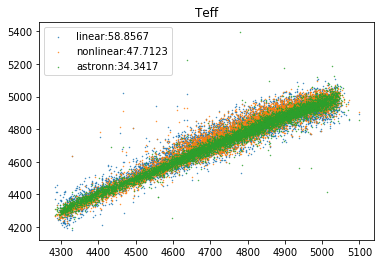

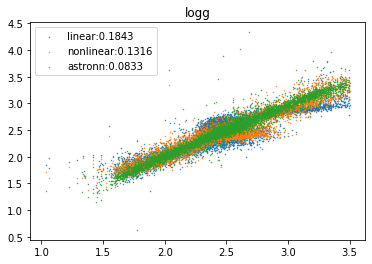

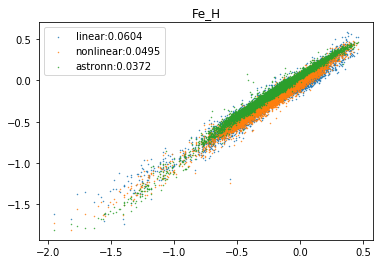

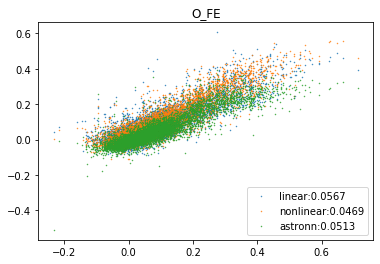

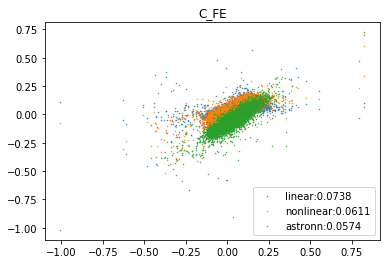

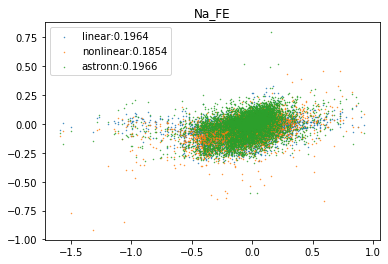

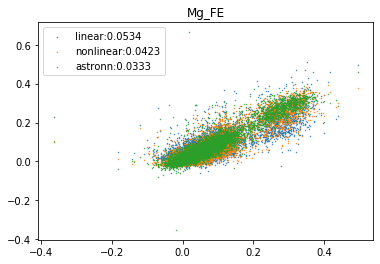

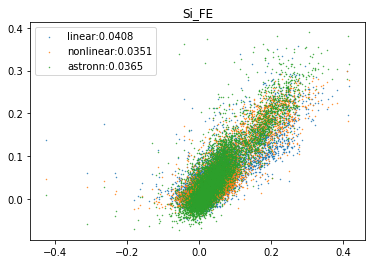

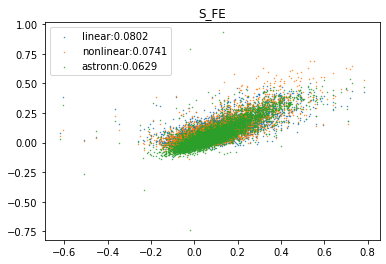

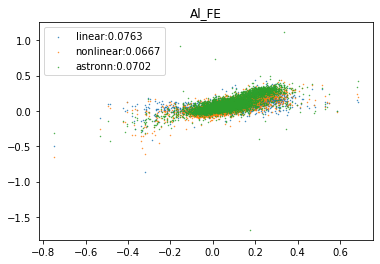

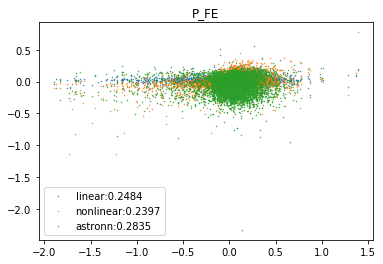

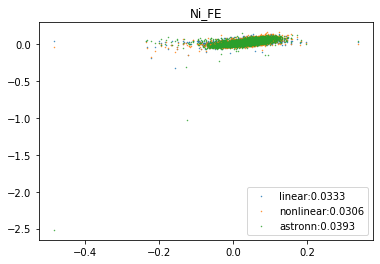

In [151]:
for i in range(len(considered_parameters)):
    plt.title(considered_parameters[i])
    nonlinear_std = np.std(nonlinear_w.predict(z).raw[:,i]-y.raw[:,i])
    linear_std = np.std(w.predict(z).raw[:,i]-y.raw[:,i])
    astronn_std = np.std(y_astronn.raw[:,i]-y.raw[:,i])


    plt.scatter(y.raw[:,i],w.predict(z).raw[:,i],s=0.2,label="linear:{:.4f}".format(linear_std))
    plt.scatter(y.raw[:,i],nonlinear_w.predict(z).raw[:,i],s=0.2,label="nonlinear:{:.4f}".format(nonlinear_std))
    plt.scatter(y.raw[:,i],y_astronn.raw[:,i],s=0.2,label="astronn:{:.4f}".format(astronn_std))

    plt.legend()
    plt.show()

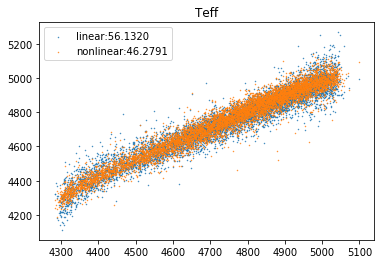

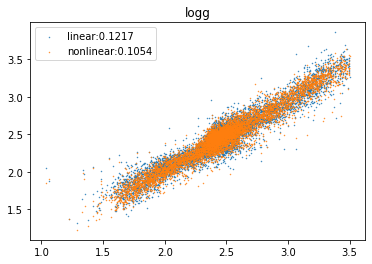

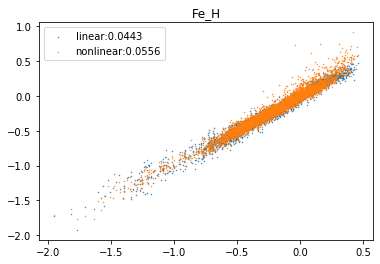

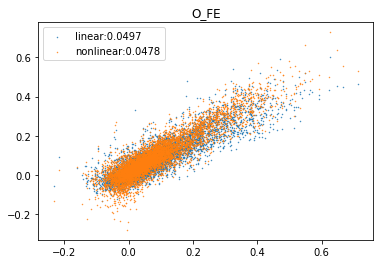

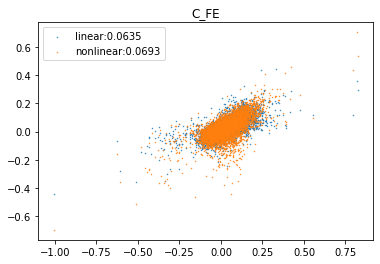

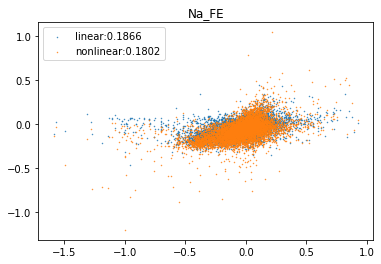

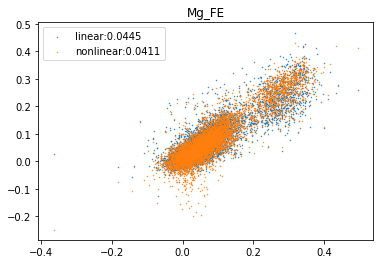

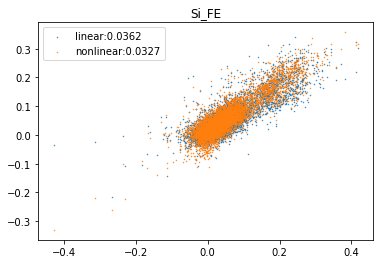

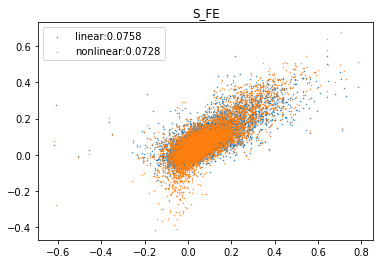

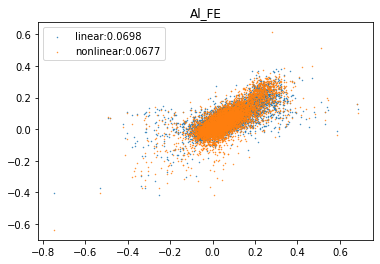

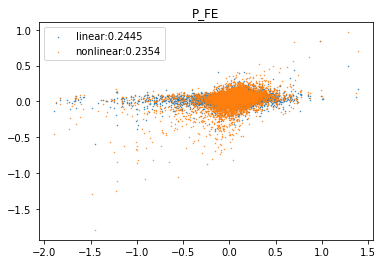

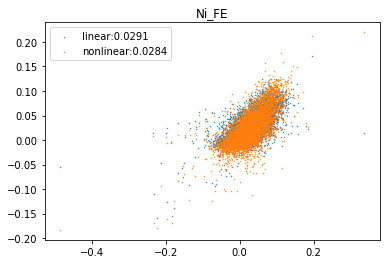

In [35]:
for i in range(len(considered_parameters)):
    plt.title(considered_parameters[i])
    nonlinear_std = np.std(nonlinear_w.predict(z).raw[:,i]-y.raw[:,i])
    linear_std = np.std(w.predict(z).raw[:,i]-y.raw[:,i])

    plt.scatter(y.raw[:,i],w.predict(z).raw[:,i],s=0.2,label="linear:{:.4f}".format(linear_std))
    plt.scatter(y.raw[:,i],nonlinear_w.predict(z).raw[:,i],s=0.2,label="nonlinear:{:.4f}".format(nonlinear_std))
    plt.legend()
    plt.show()

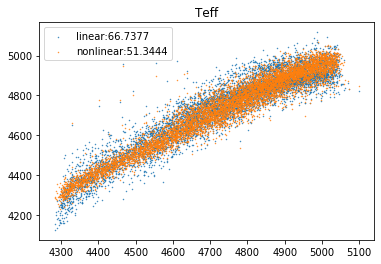

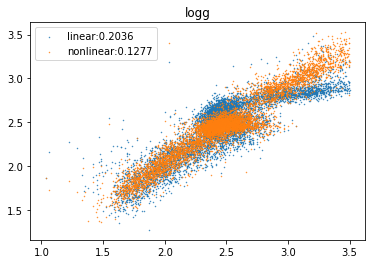

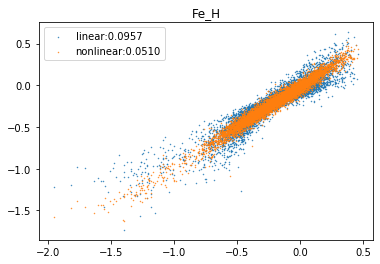

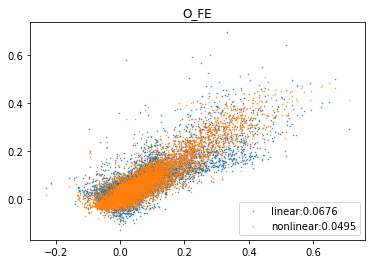

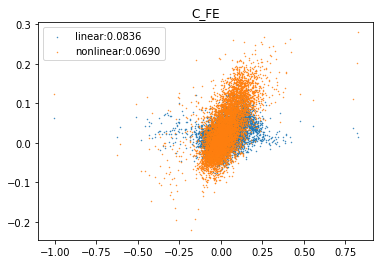

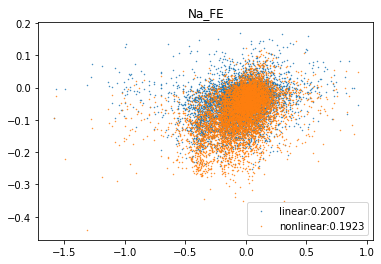

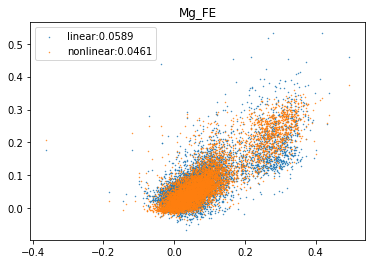

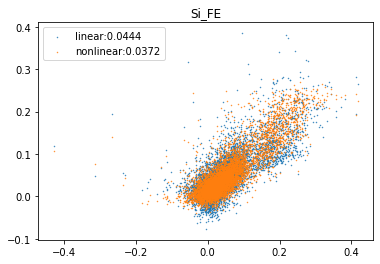

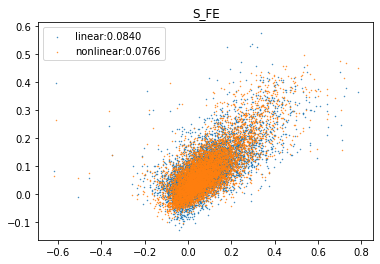

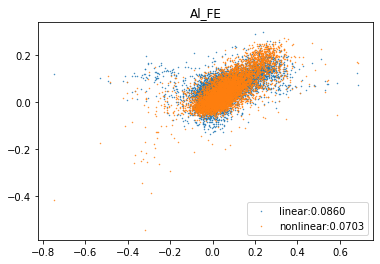

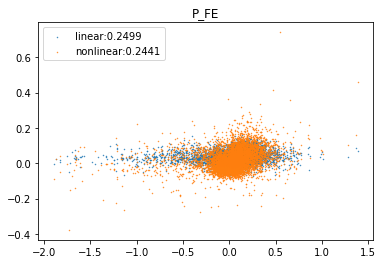

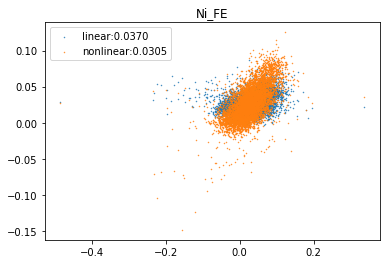

In [21]:
for i in range(len(considered_parameters)):
    plt.title(considered_parameters[i])
    nonlinear_std = np.std(nonlinear_w.predict(z).raw[:,i]-y.raw[:,i])
    linear_std = np.std(w.predict(z).raw[:,i]-y.raw[:,i])

    plt.scatter(y.raw[:,i],w.predict(z).raw[:,i],s=0.2,label="linear:{:.4f}".format(linear_std))
    plt.scatter(y.raw[:,i],nonlinear_w.predict(z).raw[:,i],s=0.2,label="nonlinear:{:.4f}".format(nonlinear_std))
    plt.legend()
    plt.show()

In [ ]:
for i in range(len(considered_parameters)):
    plt.title(considered_parameters[i])
    nonlinear_std = np.std(nonlinear_w.predict(z).raw[:,i]-y.raw[:,i])
    linear_std = np.std(w.predict(z).raw[:,i]-y.raw[:,i])

    plt.scatter(y.raw[:,i],w.predict(z).raw[:,i],s=0.2,label="linear:{:.4f}".format(linear_std))
    plt.scatter(y.raw[:,i],nonlinear_w.predict(z).raw[:,i],s=0.2,label="nonlinear:{:.4f}".format(nonlinear_std))
    plt.legend()
    plt.show()

In [ ]:
for i in range(10):
    plt.title(considered_parameters[i])
    plt.hist(nonlinear_w.predict(z).raw[:,i]-y.raw[:,i],alpha=0.5,label="diff")
    plt.hist(w.predict(z).raw[:,i]-y.raw[:,i],alpha=0.5,label="linear_diff")
    plt.hist(y.raw[:,i]-np.mean(y.raw[:,i]),alpha=0.5,label="param")
    plt.legend()
    plt.show()


## Looking at Open Clusters

In [46]:
occam = load("occam")
allStar_occam = occam["allStar"]

In [47]:
dataset_occam = AspcapDataset(allStar_occam,recenter=True,tensor_type=torch.FloatTensor,filling_dataset=dataset.dataset["aspcap"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229


In [152]:
occam_cluster_idxs = occam["cluster_idxs"]
z_occam = vector.OccamLatentVector(dataset_occam,autoencoder,occam_cluster_idxs,len(dataset_occam),order=2,interaction_only=False)


/share/splinter/ddm/taggingProject/apogeeFactory/apoNN/src/vectors.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  _,z = self.autoencoder(torch.tensor(self.dataset[idx][0]).to(device).unsqueeze(0))


occam = load("occam")
allStar_occam = occam["allStar"]
dataset_occam = ApogeeDataset(allStar_occam,outputs = ["aspcap","mask","physical","idx"])
occam_cluster_idxs = occam["cluster_idxs"]
z_occam = vector.OccamLatentVector(dataset_occam,autoencoder,occam_cluster_idxs,len(dataset_occam))


In [49]:
bad_indexes = []
for i in range(len(z_occam.raw)):
    err = np.sqrt(np.sum(((z_occam.get_x(i)-z_occam.get_x_pred(i))**2).detach().numpy()))
    print(err)
    if err>20:
        print(err)
        print(i)
        bad_indexes.append(i)
        z_occam.plot(i)
        plt.show()

/share/splinter/ddm/taggingProject/apogeeFactory/apoNN/src/vectors.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_pred,_ = self.autoencoder(torch.tensor(self.dataset[idx][0]).to(device).unsqueeze(0))


1.5481251
1.7345321
1.4361022
1.2533386
2.2339745
1.2666031
1.180826
1.6663747
1.5951198
1.658185
1.5628793
1.4263723
2.200997
2.5803971
1.9646713
1.2996354
1.7778516
1.7211108
1.1858265
1.3997321
1.9393638
1.2415081
2.4022698
2.3892326
2.6487083
1.467813
1.6761222
2.7590194
2.3521917
1.8730527
1.6269659
1.6784981
1.7828186
1.3307009
1.661458
1.1948688
1.5653025
1.1241276
1.9461629
1.6164271
1.2429328
1.5935047
1.6262972
1.4091718
2.0326467
2.682268
1.6183068
1.7193203
1.3071613
1.3688995
1.6981081
1.6554413
1.6392263
1.4727578
1.453693
1.6564244
2.199121
2.6137438
1.1561581
1.4234486
1.4098822
1.2089219
1.8366247
1.6612353
1.2335811
1.738287
1.2377881
1.8171804
1.0216405
2.0284803
1.3476136
1.7157425
2.2334404
1.6033723
1.8634142
2.050007
1.4970881
1.1449349
2.1257064
1.6953843
1.4595839
1.3191756
1.3764569
1.2574108
1.4118197
1.3504612
1.8337986
1.5522034
1.5171494
1.6779561
1.3486543
1.3806161
1.8584456
1.2934898
1.0711949
1.849443
1.3402247
1.3974485
0.971789
1.1231767
1.7164325
1.

In [ ]:
retained= np.delete(np.arange(len(z_occam.raw)),bad_indexes)
retained

dataset_occam = ApogeeDataset(allStar_occam[retained],outputs = ["aspcap","mask","physical","idx"])
occam_cluster_idxs = occam["cluster_idxs"][retained]
z_occam = vector.OccamLatentVector(dataset_occam,autoencoder,occam_cluster_idxs,len(dataset_occam))


In [153]:
clust_idxs =z_occam.registry["NGC 6819"]

Text(0.5, 1.0, 'Fe_H')

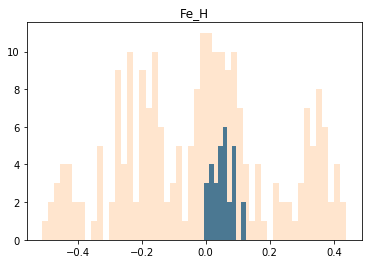

In [154]:
i=2
elem = considered_parameters[i]
plt.hist(z_occam.dataset.allStar[clust_idxs][elem],bins=9)
plt.hist(z_occam.dataset.allStar[elem],bins=50,alpha=0.2)
plt.title(elem)
#plt.xlim(-0.25,0.25)

Text(0.5, 1.0, 'Fe_H')

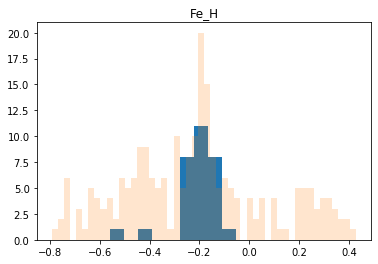

In [155]:
plt.hist(w.predict(z_occam).raw[:,i][clust_idxs],bins=9)
plt.hist(w.predict(z_occam).raw[:,i],bins=50,alpha=0.2)
#plt.hist(vector.project(z_occam.centered,w.val)[i],bins=50,alpha=0.2)

#plt.xlim(-0.25,0.25)
plt.title(considered_parameters[i])

Text(0.5, 1.0, 'Fe_H')

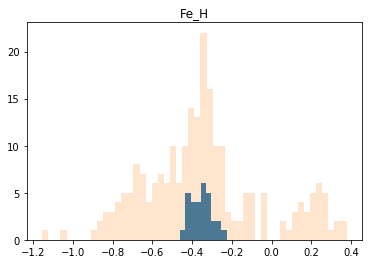

In [156]:
plt.hist(nonlinear_w.predict(z_occam).raw[:,i][clust_idxs],bins=9)
plt.hist(nonlinear_w.predict(z_occam).raw[:,i],bins=50,alpha=0.2)
#plt.hist(vector.project(z_occam.centered,w.val)[i],bins=50,alpha=0.2)

#plt.xlim(-0.25,0.25)
plt.title(considered_parameters[i])

### PCA investigation

In [160]:
whitener = PCA(n_components=z.raw.shape[1],whiten=True)#z.raw.shape[1],whiten=True)


In [161]:
whitener.fit(z.centered)

PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
    svd_solver='auto', tol=0.0, whiten=True)

In [162]:
w_z_c = whitener.transform(z.centered)
w_z_occam_c = whitener.transform(z_occam.cluster_centered)

In [181]:
pca = PCA(n_components=z.raw.shape[1])#z.raw.shape[1])


In [182]:
pca.fit(w_z_occam_c)


PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [183]:
pca.fit(w_z_c[:230,:])


PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [184]:
pca.fit(w_z_occam_c)

PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [185]:
w_z_occam_c.shape

(230, 20)

In [186]:
pca.explained_variance_

array([5.28735276e+01, 7.06615875e+00, 3.74628721e+00, 2.19788360e+00,
       1.74351124e+00, 1.14217377e+00, 5.80582334e-01, 4.28669022e-01,
       3.12598517e-01, 2.30246391e-01, 1.52954180e-01, 1.33560031e-01,
       1.07111113e-01, 9.11440333e-02, 5.62012666e-02, 4.39313919e-02,
       3.71221365e-02, 2.42595114e-02, 1.93099046e-02, 2.03666792e-03])

In [175]:
pca.explained_variance_

array([52.87352756,  7.06615875,  3.74628721,  2.1978836 ,  1.74351124,
        1.14217377,  0.58058233,  0.42866902,  0.31259852,  0.23024639])

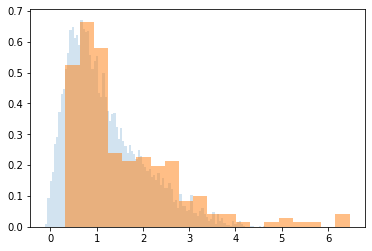

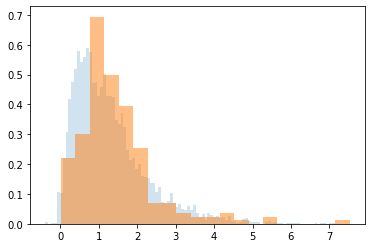

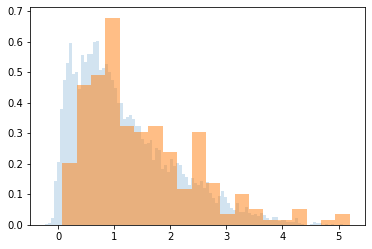

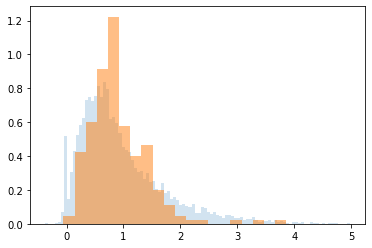

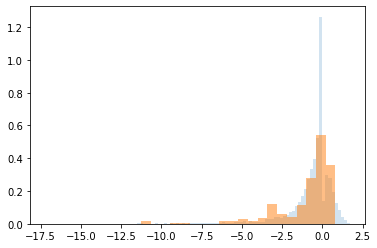

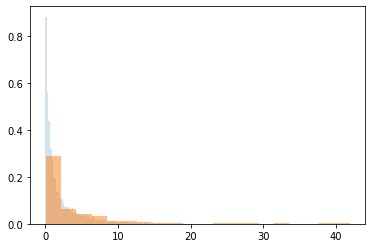

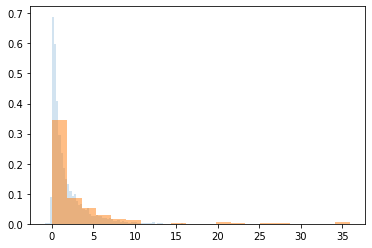

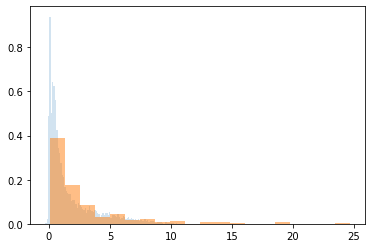

In [176]:
for i in range(8):
    plt.hist(z.raw[:,i],bins=100,alpha=0.2,density=True)
    plt.hist(z_occam.raw[:,i],alpha=0.5,bins=20,density=True)
    plt.show()

We can look at the variance along one direction across all clusters

occam:0.0020278128404450087
raw:0.9998627663655253


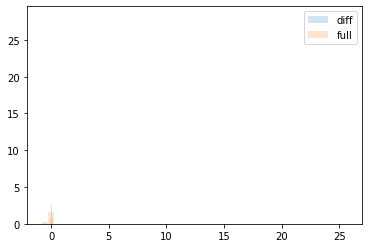

In [200]:
dim = 19
zc_b = vector.project(w_z_c,pca.components_[dim][None,:])
zoccam_b = vector.project(w_z_occam_c,pca.components_[dim][None,:])
print(f"occam:{np.var(vector.project(w_z_occam_c,pca.components_[dim][None,:]))}")
print(f"raw:{np.var(vector.project(w_z_c,pca.components_[dim][None,:]))}")

plt.hist(zoccam_b,alpha=0.2,label="diff",bins=50,density=True)
plt.hist(zc_b,alpha=0.2,label="full",bins=50, density=True)
plt.legend()


We can compare this to the raw abundances

In [ ]:
flatten = lambda l: [item for sublist in l for item in sublist]

In [ ]:
considered_parameters

In [ ]:
abundances_occam = []
elem = "Fe_H"
elem_idx = considered_parameters.index(elem)

for cluster in z_occam.registry:
    clust_idxs = z_occam.registry[cluster]
    abundances_occam.append(z_occam.dataset.allStar[clust_idxs][elem]-np.mean(z_occam.dataset.allStar[clust_idxs][elem]))
    #print(z_occam.dataset.allStar[clust_idxs][elem]-z_occam.dataset.allStar[clust_idxs][elem])
abundances_occam = flatten(abundances_occam)

In [ ]:
print(f"occam:{np.var(abundances_occam)}")
print(f"raw:{np.var(y.raw[:,elem_idx]-np.mean(y.raw[:,elem_idx]))}")

plt.hist(abundances_occam,alpha=0.2,label="diff",bins=50,density=True)
plt.hist(y.raw[:,elem_idx]-np.mean(y.raw[:,elem_idx]),alpha=0.2,label="full",bins=50, density=True)

### We can also compare to the astronn abundances

In [ ]:
y_astronn = vector.AstroNNVector(allStar[:n_data][combined_cut[:n_data]],considered_parameters)
y_astronn_occam = vector.AstroNNVector(allStar_occam,considered_parameters)

In [ ]:
i=2
plt.scatter(y_astronn.raw[:,i],y.raw[:,i],s=1,alpha=0.5)
#plt.scatter(nonlinear_w.predict(z).raw[:,i],y.raw[:,i],s=0.1,alpha=0.5)
plt.xlim(-0.1,0.1)
plt.ylim(-0.1,0.1)

In [ ]:
abundances_occam = []
elem = "Fe_H"
elem_idx = considered_parameters.index(elem)

for cluster in z_occam.registry:
    clust_idxs = z_occam.registry[cluster]
    abundances_occam.append(y_astronn_occam.raw[clust_idxs,elem_idx]-np.mean(y_astronn_occam.raw[clust_idxs,elem_idx]))
    #print(z_occam.dataset.allStar[clust_idxs][elem]-z_occam.dataset.allStar[clust_idxs][elem])
abundances_occam = flatten(abundances_occam)

In [ ]:
print(f"occam:{np.var(abundances_occam)}")
print(f"raw:{np.var(y_astronn.raw[:,elem_idx]-np.mean(y_astronn.raw[:,elem_idx]))}")

plt.hist(abundances_occam,alpha=0.2,label="diff",bins=50,density=True)
plt.hist(y_astronn.raw[:,elem_idx]-np.mean(y_astronn.raw[:,elem_idx]),alpha=0.2,label="full",bins=50, density=True)

In [ ]:
y_astronn_occam.raw[clust_idxs,elem_idx].shape

In [ ]:
dim = 4
zc_b = vector.project(w_z_c,pca.components_[dim][None,:])
zoccam_b = vector.project(w_z_occam_c,pca.components_[dim][None,:])
print(f"occam:{np.var(vector.project(w_z_occam_c,pca.components_[dim][None,:]))}")
print(f"raw:{np.var(vector.project(w_z_c,pca.components_[dim][None,:]))}")

plt.hist(zoccam_b,alpha=0.2,label="diff",bins=50,density=True)
plt.hist(zc_b,alpha=0.2,label="full",bins=50, density=True)
plt.legend()

How do these directions coincide with the raw abundances?

In [ ]:
w = vector.LinearTransformation(vector.Vector(w_z_c),y)


In [ ]:
import sklearn
sklearn.metrics.pairwise.cosine_similarity(pca.components_[9][None,:].reshape(1, -1),w.val[2].reshape(1, -1))

In [ ]:
allStar = allStar_behaved_restricted
idx=6
apogee_id,loc,telescope = allStar[idx]["APOGEE_ID"],allStar[idx]["FIELD"], allStar[idx]["TELESCOPE"]
spec = apread.aspcapStar(loc_id=str(loc),apogee_id=apogee_id,telescope=telescope,ext=0)
spec1 = apread.aspcapStar(loc_id=str(loc),apogee_id=apogee_id,telescope=telescope,ext=1)
spec2 = apread.aspcapStar(loc_id=str(loc),apogee_id=apogee_id,telescope=telescope,ext=3)


In [ ]:
plt.plot(spec[0])
plt.plot(spec1[0])
plt.plot(spec2[0])
#plt.plot(spec2[0])
plt.xlim(4000,4300)

In [ ]:
allStar_behaved_restricted =  load("allStar_training_restricted")

In [ ]:
idx=6
apogee_id,loc,telescope = allStar[idx]["APOGEE_ID"],allStar[idx]["FIELD"], allStar[idx]["TELESCOPE"]
spec = apread.aspcapStar(loc_id=str(loc),apogee_id=apogee_id,telescope=telescope,ext=0)
spec1 = apread.aspcapStar(loc_id=str(loc),apogee_id=apogee_id,telescope=telescope,ext=1)
spec2 = apread.aspcapStar(loc_id=str(loc),apogee_id=apogee_id,telescope=telescope,ext=3)

plt.plot(spec1[0])
plt.plot(dataset.dataset["aspcap"][idx])
plt.xlim(1700,1800)

In [ ]:
idx=5
apogee_id,loc,telescope = allStar[idx]["APOGEE_ID"],allStar[idx]["FIELD"], allStar[idx]["TELESCOPE"]
spec = apread.aspcapStar(loc_id=str(loc),apogee_id=apogee_id,telescope=telescope,ext=1)
spec_err = apread.aspcapStar(loc_id=str(loc),apogee_id=apogee_id,telescope=telescope,ext=2)
spec_fit = apread.aspcapStar(loc_id=str(loc),apogee_id=apogee_id,telescope=telescope,ext=3)
plt.plot(spec[0],label="raw")
plt.plot(z.get_x_pred(idx),label="nn")
#plt.plot(z.get_x(idx),label="nn")
plt.plot(spec_fit[0],label="fit")
plt.xlim(4200,4300)
plt.legend()

In [ ]:
#plt.plot(spec_fit[0]-z.get_x_pred(idx),label="fit")
#plt.plot(spec_fit[0]-z.get_x(idx).numpy(),label="fit",alpha=0.3)
plt.plot(z.get_x_pred(idx)-z.get_x(idx).numpy(),label="nn",alpha=0.3)
plt.plot(spec_err[0],label="err",alpha=0.3)
plt.xlim(500,900)
plt.ylim(0,0.02)
plt.legend()

In [ ]:
np.var(spec_fit[0]-z.get_x(idx).numpy())

In [ ]:
np.var(z.get_x_pred(idx)-z.get_x(idx).numpy())

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2,interaction_only=True)

In [ ]:
poly.fit_transform(z.raw[:,:]).shape